In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import scipy.stats as stats
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [2]:
# параметры распределений
mux0, muy0, sigmax0, sigmay0 = -3., 2., 1., 2.
mux1, muy1, sigmax1, sigmay1 = 3., 2., 3., 2.
mu0 = [mux0, muy0]
mu1 = [mux1, muy1]
cov0 = [[sigmax0, 0],[0, sigmay0]];
cov1 = [[sigmax1, 0],[0, sigmay1]];

In [3]:
# получение по 1024 примеров из каждого распредления
def sample_mult(dm0, dm1, n=1024):
    points0 = dm0.sample((n,))
    points1 = dm1.sample((n,))
    result0 = torch.zeros((n, 1))
    result1 = torch.ones((n, 1))
    return torch.cat([points0, points1],), torch.cat([result0, result1])

In [4]:
dm0 = torch.distributions.MultivariateNormal(
    torch.tensor(mu0),
    torch.tensor(cov0)
)
dm1 = torch.distributions.MultivariateNormal(
    torch.tensor(mu1),
    torch.tensor(cov1)
)

In [5]:
# Создание нейрона с 2 входами и одним выходом 
layer_mult = nn.Linear(2, 1)
print([p.data[0] for p in layer_mult.parameters()])
layer_mult_opt = optim.SGD(lr=1e-3, params=list(layer_mult.parameters()))

[tensor([-0.6017, -0.4123]), tensor(-0.4144)]


In [6]:
log_freq = 500
for i in range(10000):
    if i%log_freq == 0:
        with torch.no_grad():
            point, result = sample_mult(dm0, dm1, 100000)
            out = torch.sigmoid(layer_mult(point))
            loss = F.binary_cross_entropy(out, result)
        print('Ошибка после %d x 500 итераций: %f' %(i/log_freq, loss))
    layer_mult_opt.zero_grad()
    point, y = sample_mult(dm0, dm1, 1024)
    out = torch.sigmoid(layer_mult(point))
    loss = F.binary_cross_entropy(out, y)
    loss.backward()
    layer_mult_opt.step()

Ошибка после 0 x 500 итераций: 2.112539
Ошибка после 1 x 500 итераций: 0.466250
Ошибка после 2 x 500 итераций: 0.235431
Ошибка после 3 x 500 итераций: 0.171436
Ошибка после 4 x 500 итераций: 0.142488
Ошибка после 5 x 500 итераций: 0.124255
Ошибка после 6 x 500 итераций: 0.112468
Ошибка после 7 x 500 итераций: 0.103326
Ошибка после 8 x 500 итераций: 0.098190
Ошибка после 9 x 500 итераций: 0.092897
Ошибка после 10 x 500 итераций: 0.088020
Ошибка после 11 x 500 итераций: 0.084590
Ошибка после 12 x 500 итераций: 0.081886
Ошибка после 13 x 500 итераций: 0.079130
Ошибка после 14 x 500 итераций: 0.076576
Ошибка после 15 x 500 итераций: 0.075939
Ошибка после 16 x 500 итераций: 0.073450
Ошибка после 17 x 500 итераций: 0.072269
Ошибка после 18 x 500 итераций: 0.070515
Ошибка после 19 x 500 итераций: 0.068987


In [7]:
#Создаем точки и значения в этих точках

#
x = np.linspace(-10,10,100)
y = np.linspace(-10,10,100)
X, Y = np.meshgrid(x,y)

pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X; pos[:, :, 1] = Y

rv0 = multivariate_normal(mu0, cov0)
rv1 = multivariate_normal(mu1, cov1)

pos_tensor = torch.tensor(pos.reshape(-1, 2), dtype=torch.float)
with torch.no_grad():
    dist = torch.sigmoid(layer_mult(pos_tensor)).numpy().reshape(-1, 100)

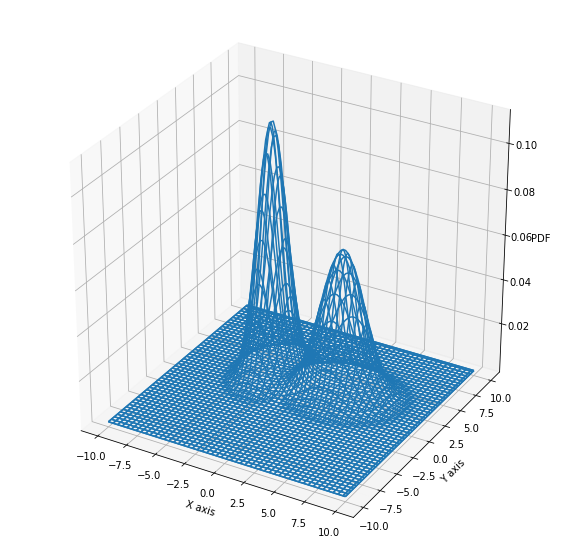

In [8]:
#Рисуем графики
plt.rcParams['figure.figsize'] = [10, 10]
fig1 = plt.figure()
ax1 = fig1.gca(projection='3d')
ax1.plot_wireframe(X, Y, rv0.pdf(pos), rstride=2, cstride=2)
ax1.plot_wireframe(X, Y, rv1.pdf(pos), rstride=2, cstride=2)


ax1.set_xlabel('X axis')
ax1.set_ylabel('Y axis')
ax1.set_zlabel('PDF')

plt.show()

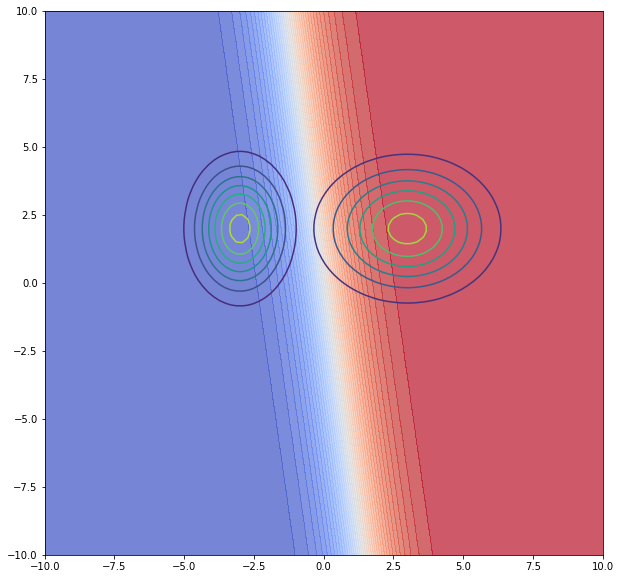

In [9]:
fig0 = plt.figure()
ax0 = fig0.add_subplot(111)
ax0.contourf(X, Y, dist, 40, alpha = 0.7, cmap='coolwarm')
ax0.contour(X, Y, rv0.pdf(pos))
ax0.contour(X, Y, rv1.pdf(pos))
plt.show()

In [10]:
print([p.data[0] for p in layer_mult.parameters()])

[tensor([1.4890, 0.2053]), tensor(-0.0890)]


In [11]:
torch.log(torch.sigmoid(torch.tensor(-100.)))

tensor(-inf)

In [12]:
F.logsigmoid(torch.tensor(-100.))

tensor(-100.)